In [1]:
!pip install keras

In [1]:

import os
import numpy as np
import cv2
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

Using TensorFlow backend.


In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials  = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
downloaded = drive.CreateFile({'id':'1yZRZGmhwvbxHmCy_-yBGlpUxocWPeT_L'})
downloaded.GetContentFile('X_data_full.npy')

In [0]:
X = np.load('X_data_full.npy')

In [0]:
downloaded = drive.CreateFile({'id':'1g-T9QB3KU112PcV5OfG1MdyoZ6NjEaZ-'})
downloaded.GetContentFile('Y_data_full.npy')

In [13]:
Y = np.load('Y_data_full.npy')
print(X.shape,Y.shape)

(53269, 64, 64, 3) (53269, 38)


In [0]:
from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y = train_test_split(X,Y,test_size=0.15,random_state=42)
x_train,x_val,y_train,y_val = train_test_split(train_x,train_y,test_size=0.1,random_state=42)

In [26]:
print(x_train.shape,y_train.shape,x_val.shape,y_val.shape,test_x.shape,test_y.shape)

(40750, 64, 64, 3) (40750, 38) (4528, 64, 64, 3) (4528, 38) (7991, 64, 64, 3) (7991, 38)


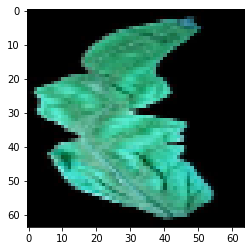

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [27]:
import matplotlib.pyplot as plt
plt.imshow(train_x[100])
plt.show()
y_train[21000]

In [0]:
from keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [0]:
n_classes  =38

In [0]:
#MODEL

model = Sequential()
inputShape = (64, 64, 3)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (3, 64, 64)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
activation_8 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 21, 21, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
activation_9 (Activation)    (None, 21, 21, 64)       

In [0]:
opt =Adam(lr = 1e-3,decay=1e-3/25)
model.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer=opt)

In [0]:
from keras.callbacks import *
filepath="/content/gdrive/My Drive/Colab Notebooks/CNN_weights/epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [34]:
history = model.fit_generator(aug.flow(x_train,y_train, batch_size=32),validation_data=(test_x, test_y),
                                   steps_per_epoch=len(train_x)//32 ,epochs=50, verbose=1,callbacks=callbacks_list)

Epoch 1/50
1414/1414 [==============================] - 63s 45ms/step - loss: 0.0655 - acc: 0.9798 - val_loss: 0.0455 - val_acc: 0.9857

Epoch 00001: val_acc improved from -inf to 0.98574, saving model to /content/gdrive/My Drive/Colab Notebooks/CNN_weights/epochs:001-val_acc:0.986.hdf5
Epoch 2/50
1414/1414 [==============================] - 61s 43ms/step - loss: 0.0396 - acc: 0.9862 - val_loss: 0.0431 - val_acc: 0.9856

Epoch 00002: val_acc did not improve from 0.98574
Epoch 3/50
1414/1414 [==============================] - 61s 43ms/step - loss: 0.0315 - acc: 0.9889 - val_loss: 0.0414 - val_acc: 0.9858

Epoch 00003: val_acc improved from 0.98574 to 0.98580, saving model to /content/gdrive/My Drive/Colab Notebooks/CNN_weights/epochs:003-val_acc:0.986.hdf5
Epoch 4/50
1414/1414 [==============================] - 61s 43ms/step - loss: 0.0281 - acc: 0.9899 - val_loss: 0.0356 - val_acc: 0.9883

Epoch 00004: val_acc improved from 0.98580 to 0.98832, saving model to /content/gdrive/My Drive/C

In [0]:
X